# FDA Reading Room 483 Analysis

In [1]:
from datetime import date
print("Script last ran on {}".format(date.today().strftime("%m/%d/%Y")))

Script last ran on 05/10/2021


In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import lxml
import html5lib 
from bs4 import BeautifulSoup
import janitor
import tempfile
import os # to get current opperating system

import cv2
from PIL import Image
from pathlib import Path

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\ncruickshank\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

# selenium functions
from selenium import webdriver
from selenium.webdriver.common.keys import Keys #allow  you to enter keystrokes into fields
from selenium.webdriver.support.ui import Select #allow you to select a dropdown item
from selenium.webdriver.support.ui import WebDriverWait #lets you modify a field before proceeding
from selenium.common.exceptions import NoSuchElementException 

## Step 1: Scrape Data Table and List of URLs to Form 483s from URL

__Establishment Types to Filter By__  
Outsourcing Facility, Producer of Sterile and Non Sterile Drug Products, Producer of Sterile Drug Products, Producer of Non Sterile Drug Products, Manufacturer

In [3]:
cwd = os.getcwd()
temp483pdf_filepath = cwd + '\\temp483pdf'
temp483images_filepath = cwd + '\\temp483images'

op = webdriver.ChromeOptions()
prefs = {"download.default_directory": temp483pdf_filepath,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
         "download.extensions_to_open": "applications/pdf",
        "plugins.always_open_pdf_externally": True}
#prefs2 = {"download.prompt_for_download": False,
#        "download.directory_upgrade": True,
#         "download.extensions_to_open": "applications/pdf",
#        "plugins.always_open_pdf_externally": True}
op.add_experimental_option("prefs", prefs)
driver = webdriver.Chrome()

table class = lcsd-datatable--ora-foia-reading table table-bordered dataTable no footer dtr-inline

In [4]:
# use driver to open website
url = 'https://www.fda.gov/about-fda/office-regulatory-affairs/ora-foia-electronic-reading-room'
driver.get(url)

In [5]:
# utilize the filter box to select only 483s (value = 0)
select = Select(driver.find_element_by_css_selector('#lcds-datatable-filter--record-filter'))
select.select_by_visible_text("483")

In [6]:
# get the table headers
## read the datatable of page 1 for the sake of retrieving headers
datatable_xpath = '//*[@id="DataTables_Table_0"]'
records = driver.find_element_by_xpath(datatable_xpath)
records_innerhtml = records.get_attribute('innerHTML')
soup = BeautifulSoup(records_innerhtml, 'html.parser')
trs = soup.findAll('tr')
headers = []
for th in trs[0].findAll('th'):
    headers.append(th.text)
headers

# scrape all rows in each page of the paginated datatable
final_page = int(driver.find_element_by_xpath('//*[@id="DataTables_Table_0_paginate"]/ul/li[8]').text)
rows = []
for page in range(1, final_page + 1):
    
    datatable_xpath = '//*[@id="DataTables_Table_0"]'
    records = driver.find_element_by_xpath(datatable_xpath)
    records_innerhtml = records.get_attribute('innerHTML')
    soup = BeautifulSoup(records_innerhtml, 'html.parser')
    trs = soup.findAll('tr')
    
    for i in range(1, len(trs)):
        tds = []
        #page_rows = []
        for td in trs[i].findAll('td'):
            a = td.findAll('a')
            spans = td.findAll('span')
            inputs = td.findAll('input')
            ret = ""
            if len(a) != 0 or len(spans) != 0 or len(inputs) != 0:
                if len(a) != 0:
                    for link in a:
                        ret += link.text + ' - '+link['href']
                if len(spans) != 0:
                    for span in spans:
                        ret += span.text + ' - '+span['title']
                if len(inputs) != 0:
                    for inp in inputs:
                        if inp.has_attr('value'):
                            if inp.has_attr('type'):
                                if inp['type'] == 'hidden':
                                    ret += inp['value']
            else: 
                ret = td.text if td.text != '' and td.text != '\n' else "NaN"
            tds.append(ret)
        rows.append(tds)
        
    driver.find_element_by_xpath('//*[@id="DataTables_Table_0_next"]/a').click() #//*[@id="DataTables_Table_0_next"]/a
    #driver.find_element_by_class_name('paginate_button next').click()

len(rows)

1466

In [7]:
driver.find_element_by_xpath('//*[@id="DataTables_Table_0_next"]/a').click()
#driver.find_element_by_class_name('paginate_button next').click()

In [8]:
df = pd.DataFrame(rows, columns = headers)
df[['Record Type', 'HREF']] = df['Record Type'].str.split(' - ', 1, expand = True)
df = df.clean_names()
df['pdf_url'] = 'https://www.fda.gov' + df['href']
df.head()

,record_date,fei_number,company_name,record_type,state,establishment_type,publish_date,href,pdf_url
0,04/20/2021,3015448605,"Emergent Manufacturing Operations Baltimore, LLC.",483,Maryland,Vaccine Manufacturer,04/21/2021,/media/147762/download,https://www.fda.gov/media/147762/download
1,02/05/2021,3006701521,Midwestern Pet Foods Chickasha Operation,483,Oklahoma,Pet Food Manufacturer,04/19/2021,/media/146854/download,https://www.fda.gov/media/146854/download
2,01/28/2021,3011761321,"Wells Pharmacy, Inc",483,Tennessee,Outsourcing Facility,03/31/2021,/media/147184/download,https://www.fda.gov/media/147184/download
3,01/05/2021,3011834594,"Juno Therapeutics, Inc.",483 Response,Washington,CAR-T Cell Therapy Manufacturer,01/25/2021,/media/145363/download,https://www.fda.gov/media/145363/download
4,12/10/2020,3013629214,"Lonza Houston, Inc",483,Texas,Manufacturer,01/14/2021,/media/145127/download,https://www.fda.gov/media/145127/download


In [9]:
#list(df.groupby('establishment_type').size().reset_index(name = 'count').sort_values(by = 'count', ascending = False).establishment_type)
relavent_establishment_types = ['Producer of Sterile Drug Products', 'Outsourcing Facility', 'Manufacturer', 'Drug Manufacturer',
                               'Compounding Pharmacy', 'Producer of Non Sterile Drug Products', 'Sterile Drug Manufacturer', 
                               'Pharmaceutical Manufacturer', 'Human Drug Manufacturer', 'Biological Drug Manufacturer', 
                               'Active Pharmaceutical Ingredient Manufacturer', 'Manufacturer and Repacker', 
                               'Active Pharmaceutical Ingredient & Finished Dosage Manufacturer', 'Biotech API Manufacturer',
                               'Finished Pharmaceutical Manufacturer']
# include cosmetics in this list
df2 = df[df['establishment_type'].isin(relavent_establishment_types)].reset_index()
df2['record_date'] = pd.to_datetime(df2['record_date'])
df2['publish_date'] = pd.to_datetime(df2['publish_date'])
df2.shape

(1036, 10)

In [10]:
df2

,index,record_date,fei_number,company_name,record_type,state,establishment_type,publish_date,href,pdf_url
0,2,2021-01-28,3011761321,"Wells Pharmacy, Inc",483,Tennessee,Outsourcing Facility,2021-03-31,/media/147184/download,https://www.fda.gov/media/147184/download
1,4,2020-12-10,3013629214,"Lonza Houston, Inc",483,Texas,Manufacturer,2021-01-14,/media/145127/download,https://www.fda.gov/media/145127/download
2,5,2020-11-05,3006271438,"Novel Laboratories, Inc. d.b.a LUPIN",483,New Jersey,Drug Manufacturer,2021-01-14,/media/145108/download,https://www.fda.gov/media/145108/download
3,6,2020-11-02,3005543749,"Hopkinton Drug, Inc.",483,Massachusetts,Producer of Non Sterile Drug Products,2021-01-29,/media/145540/download,https://www.fda.gov/media/145540/download
4,7,2020-10-29,3010039017,"Advanced Nutriceuticals, LLC",483,Indiana,Producer of Sterile Drug Products,2020-12-16,/media/144544/download,https://www.fda.gov/media/144544/download
...,...,...,...,...,...,...,...,...,...,...
1031,1459,NaT,NaN,Arnold Professional Pharmacy,483,Maryland,Producer of Sterile Drug Products,2019-03-22,/media/116510/download,https://www.fda.gov/media/116510/download
1032,1460,NaT,NaN,"Transdermal Therapeutics, Inc.",483 Response,Alabama,Drug Manufacturer,2019-03-22,/media/116828/download,https://www.fda.gov/media/116828/download
1033,1461,NaT,NaN,NaN,483 Response,Alabama,Drug Manufacturer,2019-03-22,/media/89847/download,https://www.fda.gov/media/89847/download
1034,1462,NaT,NaN,"South Coast Specialty Compounding, Inc.",483,California,Producer of Sterile Drug Products,2019-03-22,/media/116612/download,https://www.fda.gov/media/116612/download


In [11]:
driver.quit()

## Step 2: Read each 483 PDF through an OCR machine into notebook

__Useful Links__  
https://towardsdatascience.com/extracting-text-from-scanned-pdf-using-pytesseract-open-cv-cd670ee38052  
https://stackoverflow.com/questions/43149534/selenium-webdriver-how-to-download-a-pdf-file-with-python  
https://stackoverflow.com/questions/46184239/extract-a-page-from-a-pdf-as-a-jpeg  (has a useful comment about making a pdf into one long JPEG)  

In [12]:
driver = webdriver.Chrome(options = op)

In [13]:
list_urls = list(df2.pdf_url)
test_pdf_url = df2.pdf_url[0]
test_record_reference = str(df2.company_name[0]) + " " + str(df2.record_date[1].strftime('%Y-%m-%d'))

In [14]:
driver.get(test_pdf_url) # does succesfully download into the right folder
#for pdf in df2[:10].pdf_url:
#    driver.get(pdf)

In [15]:
#!pip install pdf2image 
from pdf2image import convert_from_path

pdf = temp483pdf_filepath + "\\" + "WellsPharmacy508ed_0.pdf" #"\WellsPharmacy508ed_0.pdf"

with tempfile.TemporaryDirectory() as temp_dir:
    pages = convert_from_path(pdf, 300, output_folder = temp_dir)
    i = 1
    
    for page in pages:
        if i < 10:
            pn = "0" + str(i)
        else: 
            pn = str(i)
        image_name = temp483images_filepath + "\\" + test_record_reference + " - Page " + str(pn) + " of " + str(len(pages)) + ".jpg"
        page.save(image_name, 'JPEG')
        i = i + 1

In [16]:
driver.quit()

#### Cropping and tidying images

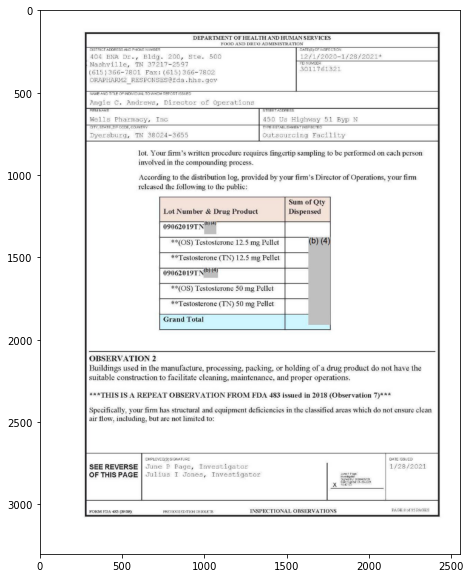

In [17]:
test_image = temp483images_filepath + "\\" + "Wells Pharmacy, Inc  2020-12-10 - Page 08 of 15.jpg"
image = cv2.imread(test_image)

plt.figure(figsize=(10,10))
plt.imshow(image)

'Wells Pharmacy, Ine\n\x0c'

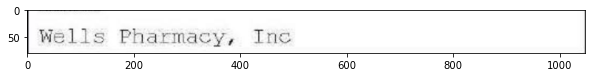

In [36]:
# firm name
firm_coord = [(280, 615), (1328, 695)]
firm = image[firm_coord[0][1]:firm_coord[1][1], firm_coord[0][0]:firm_coord[1][0]]

plt.figure(figsize = (10,10))
plt.imshow(firm)

text = str(pytesseract.image_to_string(firm))
text

'Outsourcing Facility\n\x0c'

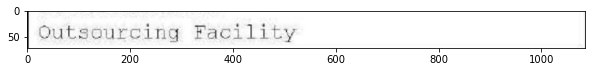

In [52]:
# facility type
type_coord = [(1330, 718), (2415, 790)]
firm_type = image[type_coord[0][1]:type_coord[1][1], type_coord[0][0]:type_coord[1][0]]

plt.figure(figsize = (10,10))
plt.imshow(firm_type)

text = str(pytesseract.image_to_string(firm_type))
text

'June P Page, Investigator\nJulius I Jones, Investigator\n\x0c'

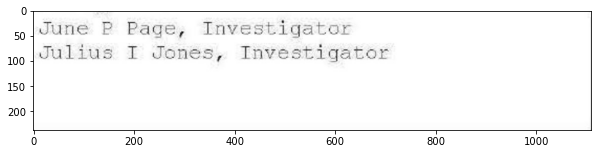

In [18]:
# list of auditors
auditors_coord = [(630, 2735), (1740, 2972)]
auditors = image[auditors_coord[0][1]:auditors_coord[1][1], auditors_coord[0][0]:auditors_coord[1][0]]

plt.figure(figsize=(10,10))
plt.imshow(auditors)

auditors_filepath = temp483images_filepath + "\\" + test_record_reference + " Auditors.jpg"
cv2.imwrite(auditors_filepath, auditors)

#ret, thresh1 = cv2.threshold(auditors, 120, 255, cv2.THRESH_BINARY)
text = str(pytesseract.image_to_string(auditors))
text

# convert the image to black and white for better OCR
#ret,thresh1 = cv2.threshold(img,120,255,cv2.THRESH_BINARY)

# pytesseract image to string to get results
#text = str(pytesseract.image_to_string(thresh1, config='--psm 6'))
#print(text)

'Dyersburg, ITN 38024-3655\n\x0c'

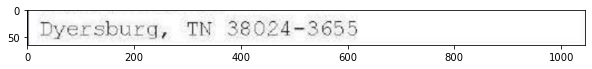

In [53]:
# city of facility
city_coord = [(280, 725), (1325, 790)]
facility_city = image[city_coord[0][1]:city_coord[1][1], city_coord[0][0]:city_coord[1][0]]

plt.figure(figsize=(10,10))
plt.imshow(facility_city)

city_filepath = temp483images_filepath + "\\" + test_record_reference + " City.jpg"
cv2.imwrite(city_filepath, facility_city)

text = str(pytesseract.image_to_string(facility_city))
text

'/12/1/2020-1/28/2021+\n\x0c'

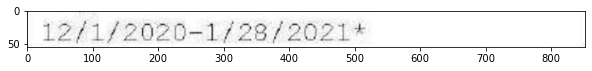

In [54]:
# date range of inspection
audit_dates_coord = [(1558, 250), (2410, 305)]
audit_dates = image[audit_dates_coord[0][1]:audit_dates_coord[1][1], audit_dates_coord[0][0]:audit_dates_coord[1][0]]

plt.figure(figsize=(10,10))
plt.imshow(audit_dates)

audit_dates_filepath = temp483images_filepath + "\\" + test_record_reference + " Audit Dates.jpg"
cv2.imwrite(audit_dates_filepath, audit_dates)

text = str(pytesseract.image_to_string(audit_dates))
text

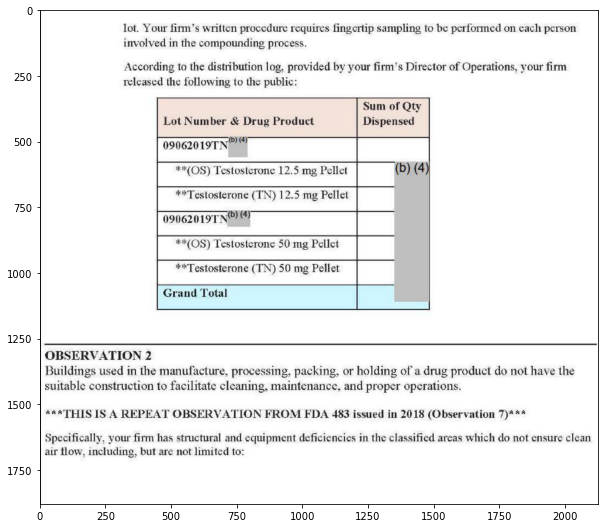

In [55]:
# observations
obs_coord = [(280, 800), (2405, 2680)]
observations = image[obs_coord[0][1]:obs_coord[1][1], obs_coord[0][0]:obs_coord[1][0]]

plt.figure(figsize=(10,10))
plt.imshow(observations)

In [59]:
cwd = os.getcwd()
temp483pdf_filepath = cwd + '\\temp483pdf'
temp483images_filepath = cwd + '\\temp483images'
folder = Path(temp483pdf_filepath)
images = []
for file in folder.glob('*.jpg'):
    #print(file.name)
    
    # crop each page of the pdf
    image_path = temp483images_filepath + "\\" + str(file.name)
    image = cv2.imread(image_path)
    obs_coord = [(280, 800), (2405, 2680)]
    observations = image[obs_coord[0][1]:obs_coord[1][1], obs_coord[0][0]:obs_coord[1][0]]
    
    # save cropped images
    observations_filepath = temp483images_filepath + "\\" + str(file.name) + " Observations.jpg"
    cv2.imwrite(observations_filepath, observations)
    
    images.append(observations_filepath)
    #plt.figure(figsize=(10,10))
    #plt.imshow(observations)
        
    print(observations_filepath)

In [60]:
imgs = list(map(Image.open, images))

# find minimum width of images
min_img_width = min(i.width for i in imgs)
# find total height of all images
total_height = 0
for i, img in enumerate(imgs):
    total_height += imgs[i].height

merged_image = Image.new(imgs[0].mode, (min_img_width, total_height))
# paste images together one by one
y = 0
for img in imgs:
    merged_image.paste(img, (0, y))
    y += img.height
merged_image_name = temp483images_filepath + "\\" + test_record_reference + " Observations Merged.jpg"
merged_image.save(merged_image_name)

ValueError: min() arg is an empty sequence

In [ ]:
text = str(pytesseract.image_to_string(merged_image))

#### Putting it all together

In [61]:
df2

,index,record_date,fei_number,company_name,record_type,state,establishment_type,publish_date,href,pdf_url
0,2,2021-01-28,3011761321,"Wells Pharmacy, Inc",483,Tennessee,Outsourcing Facility,2021-03-31,/media/147184/download,https://www.fda.gov/media/147184/download
1,4,2020-12-10,3013629214,"Lonza Houston, Inc",483,Texas,Manufacturer,2021-01-14,/media/145127/download,https://www.fda.gov/media/145127/download
2,5,2020-11-05,3006271438,"Novel Laboratories, Inc. d.b.a LUPIN",483,New Jersey,Drug Manufacturer,2021-01-14,/media/145108/download,https://www.fda.gov/media/145108/download
3,6,2020-11-02,3005543749,"Hopkinton Drug, Inc.",483,Massachusetts,Producer of Non Sterile Drug Products,2021-01-29,/media/145540/download,https://www.fda.gov/media/145540/download
4,7,2020-10-29,3010039017,"Advanced Nutriceuticals, LLC",483,Indiana,Producer of Sterile Drug Products,2020-12-16,/media/144544/download,https://www.fda.gov/media/144544/download
...,...,...,...,...,...,...,...,...,...,...
1031,1459,NaT,NaN,Arnold Professional Pharmacy,483,Maryland,Producer of Sterile Drug Products,2019-03-22,/media/116510/download,https://www.fda.gov/media/116510/download
1032,1460,NaT,NaN,"Transdermal Therapeutics, Inc.",483 Response,Alabama,Drug Manufacturer,2019-03-22,/media/116828/download,https://www.fda.gov/media/116828/download
1033,1461,NaT,NaN,NaN,483 Response,Alabama,Drug Manufacturer,2019-03-22,/media/89847/download,https://www.fda.gov/media/89847/download
1034,1462,NaT,NaN,"South Coast Specialty Compounding, Inc.",483,California,Producer of Sterile Drug Products,2019-03-22,/media/116612/download,https://www.fda.gov/media/116612/download


In [62]:
def every_downloads_chrome(driver):
    if not driver.current_url.startswith("chrome://downloads"):
        driver.get("chrome://downloads/")
    return driver.execute_script("""
        var items = document.querySelector('downloads-manager')
            .shadowRoot.getElementById('downloadsList').items;
        if (items.every(e => e.state === "COMPLETE"))
            return items.map(e => e.fileUrl || e.file_url);
        """)

In [77]:
driver.quit()

cwd = os.getcwd()
temp483pdf_filepath = cwd + '\\temp483pdf'
temp483images_filepath = cwd + '\\temp483images'
temp483images2_filepath = cwd + '\\temp483images2'

driver = webdriver.Chrome(options = op)

#pdf_paths = []

# STEP 1: Download each PDF from the reading room
for record in df2[5:8].pdf_url:
    print(record)
    
    # download the pdf
    driver.get(record)
    
    # get file names once fully dowloaded
    pdfs_path = WebDriverWait(driver, 120, 1).until(every_downloads_chrome)

print(pdfs_path)
len(pdfs_path)
#driver.quit()

https://www.fda.gov/media/144715/download
https://www.fda.gov/media/144723/download
https://www.fda.gov/media/144725/download
['file:///C:/Users/ncruickshank/Documents/data_analysis/github/fda_audit_analysis/temp483pdf/HealthyChoice508ed.pdf', 'file:///C:/Users/ncruickshank/Documents/data_analysis/github/fda_audit_analysis/temp483pdf/Stokes508ed_0.pdf', 'file:///C:/Users/ncruickshank/Documents/data_analysis/github/fda_audit_analysis/temp483pdf/EHTPharmacy508ed.pdf']


3

In [86]:
# STEP 2: For each pdf, convert each page into jpg and save it in a new folder

rows = []
images_folder = Path(temp483images_filepath)
for pdf in pdfs_path:
    # get pdf name
    str_start = pdf.find("temp483pdf/") + len("temp483pdf/")
    str_end = pdf.find(".pdf")
    file_path = temp483pdf_filepath + "\\" + pdf[str_start:]
    file_name = pdf[str_start:str_end]
    
    # convert the pdf into jpgs
    images = []
    with tempfile.TemporaryDirectory() as temp_dir:
        pages = convert_from_path(file_path, 300, output_folder = temp_dir)
        i = 1
        
        for page in pages:
            if i < 10:
                pn = "0" + str(i)
            else: 
                pn = str(i)
            image_name = temp483images_filepath + "\\" + file_name + " - Page " + str(pn) + " of " + str(len(pages)) + ".jpg"
            page.save(image_name, 'JPEG')
            images.append(image_name)
            i = i + 1
    
    row = []
    
    # crop the first page to parse info from headers and footers
    page1 = cv2.imread(images[0])
    
    ## firm name
    firm_coord = [(280, 615), (1328, 695)]
    firm = page1[firm_coord[0][1]:firm_coord[1][1], firm_coord[0][0]:firm_coord[1][0]]
    firm_text = str(pytesseract.image_to_string(firm))
    row.append(firm_text)
    
    # establishment type
    type_coord = [(1330, 718), (2415, 790)]
    firm_type = image[type_coord[0][1]:type_coord[1][1], type_coord[0][0]:type_coord[1][0]]
    establishment_type_text = str(pytesseract.image_to_string(firm_type))
    row.append(establishment_type_text)
    
    ## facility city
    city_coord = [(280, 725), (1325, 790)]
    facility_city = page1[city_coord[0][1]:city_coord[1][1], city_coord[0][0]:city_coord[1][0]]


    #city_filepath = temp483images_filepath + "\\" + file_name + " City.jpg"
    #cv2.imwrite(city_filepath, facility_city)

    city_text = str(pytesseract.image_to_string(facility_city))
    row.append(city_text)
    
    ## auditors
    auditors_coord = [(630, 2735), (1740, 2972)]
    auditors = page1[auditors_coord[0][1]:auditors_coord[1][1], auditors_coord[0][0]:auditors_coord[1][0]]

    #auditors_filepath = temp483images2_filepath + "\\" + file_name + " Auditors.jpg"
    #cv2.imwrite(auditors_filepath, auditors)

    auditors_text = str(pytesseract.image_to_string(auditors))
    row.append(auditors_text)

    ## audit dates
    audit_dates_coord = [(1558, 250), (2410, 305)]
    audit_dates = page1[audit_dates_coord[0][1]:audit_dates_coord[1][1], audit_dates_coord[0][0]:audit_dates_coord[1][0]]

    #audit_dates_filepath = temp483images_filepath + "\\" + file_name + " Audit Dates.jpg"
    #cv2.imwrite(audit_dates_filepath, audit_dates)

    dates_text = str(pytesseract.image_to_string(audit_dates))
    row.append(dates_text)
    
    # observations crop
    cropped_observations = []
    for file in images_folder.glob("*.jpg"):
        
        ## read the image into the for loop
        image_path = temp483images_filepath + "\\" + str(file.name)
        image = cv2.imread(image_path)
    
        ## crop each JPG page of the original PDF for just the observation section
        obs_coord = [(280, 800), (2405, 2680)]
        observations = image[obs_coord[0][1]:obs_coord[1][1], obs_coord[0][0]:obs_coord[1][0]]
        
        ## save the cropped images
        observations_filepath = temp483images2_filepath + "\\" + str(file.name) + " Observations.jpg"
        cv2.imwrite(observations_filepath, observations)
        cropped_observations.append(observations_filepath)
    
    # open the cropped observation images into a new PIL
    crops = list(map(Image.open, cropped_observations))
    
    # find minimum width of crops
    min_crop_width = min(i.width for i in crops)
    
    # find total height of all images
    total_height = 0
    for i, crop in enumerate(crops):
        total_height += crops[i].height
    
    # create perimeter of merged image
    merged_image = Image.new(crops[0].mode, (min_crop_width, total_height))
    # paste images together one by one
    y = 0
    for crop in crops:
        merged_image.paste(crop, (0, y))
        y += crop.height
    merged_image_name = temp483images2_filepath + "\\" + file_name + " Observations Merged.jpg"
    merged_image.save(merged_image_name)
    
    # need to figure out how to prevent merged observation images from stacking on top of each other
    cropped_observations.clear()
    crops.clear()
    #min_crop_width = 0, #total_height = 0
    merged_image = 0 # trying to clear the merged image?
        ## merge the obseration crops by stacking each JPG page on top of each other

        ## save merged images into temp483images2
    
    rows.append(row)
    
    # delete the indidivudal JPG page files from temp483images

In [82]:
headers = ['firm_name', 'establishment_type', 'facility_city', 'auditors', 'audit_dates']
rows
f483 = pd.DataFrame(rows, columns = headers)
f483

,firm_name,establishment_type,facility_city,auditors,audit_dates
0,Healthy Choice Compounding LLC\n,,"Elmsford, NY 10523-1305\n\n \n","Mindy M Chou, Investigator\n",9/17/2020-9/24/2020*\n
1,Stokes Healthcare Inc. dba Epicur Pharma\n,,"Mount Laurel, NJ 08054-2211\n",ay anaes PR are of dhe a sth ei EE\n\nRussell ...,-9/24/2020-10/9/2020*\n
2,EHT Pharmacy LLC dba Curexa\n,,"Egg Harbor Township, NJ 08234-7749\n",See Soe a ge ee Ont seed a a\n\nNancy M Espina...,-8/26/2020-10/9/2020*\n


In [24]:
# STEP 3: Delete each PDF from the original folder.
## Now that each PDF has been converted to a collection of JPGs, the PDFs are no longer needed.
folder = Path(temp483pdf_filepath)
for file in folder.glob('*.pdf'):
    file.unlink()

#### Unused Code

In [ ]:
#!pip install opencv-python
import cv2
from PIL import Image

def mark_region(image_path):
    
    im = cv2.imread(image_path)

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 0)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    line_items_coordinates = []
    for c in cnts:
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)

        if y >= 600 and x <= 1000:
            if area > 10000:
                image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
                line_items_coordinates.append([(x,y), (2200, y+h)])

        if y >= 2400 and x<= 2000:
            image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
            line_items_coordinates.append([(x,y), (2200, y+h)])


    return image, line_items_coordinates

In [ ]:
#for pdf in pdfs:
    #download pdf to temp483pdf folder
    #for page in pages:
        #convert page to a png file
        #save that file in temp483images
    #perform OCR on those images
    #save text file as ocr_483_audit (figure the naming convention out)
    #delete images
    #delete pdf

In [ ]:
#from PIL import Image
#
#def convert_pdf_to_image(file_path, output_path):
#    # save temp image files in temp dir, delete them after we are finished
#    with tempfile.TemporaryDirectory() as temp_dir:
#        # convert pdf to multiple image
#        images = convert_from_path(file_path, output_folder=temp_dir)
#        # save images to temporary directory
#        temp_images = []
#        for i in range(len(images)):
#            image_path = f'{temp_dir}/{i}.jpg'
#            images[i].save(image_path, 'JPEG')
#            temp_images.append(image_path)
#        # read images into pillow.Image
#        imgs = list(map(Image.open, temp_images))
#    # find minimum width of images
#    min_img_width = min(i.width for i in imgs)
#    # find total height of all images
#    total_height = 0
#    for i, img in enumerate(imgs):
#        total_height += imgs[i].height
#    # create new image object with width and total height
#    merged_image = Image.new(imgs[0].mode, (min_img_width, total_height))
#    # paste images together one by one
#    y = 0
#    for img in imgs:
#        merged_image.paste(img, (0, y))
#        y += img.height
#    # save merged image
#    merged_image.save(output_path)
#    return output_path
#
#convert_pdf_to_image(pdf, str(temp483images_filepath) + "image.jpeg")

## Step 3: Tidy each document into a corpus

## Step 4: Perform Topic Modeling on Most Recent 1 Year of Drug Observations

## References

__Useful Links__  
https://medium.com/@sarfrazarshad/scraping-dynamically-created-tables-196b7cbe6c84  
https://stackoverflow.com/questions/56757261/extract-href-using-pandas-read-html/56757977  
https://stackoverflow.com/questions/60757571/python-pandas-parse-html-table-to-get-hidden-values-and-links  
https://stackoverflow.com/questions/51092362/selenium-clicking-to-next-page-until-on-last-page